In [3]:
import numpy as np
import pandas as pd
import gc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
import pickle
import shap
import matplotlib.pyplot as plt
import xgboost

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from functools import partial

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from bo_parameters import *

In [4]:
lgbm_tuned = {
    "learning_rate" : 0.10056036392812367, 
    "max_depth" : 9, 
    "n_estimators" : 574
}
# lgbm_tuned += LIGHTGBM_PARAMS

xgb_tuned = {
    "learning_rate" : 0.12505580158355423, 
    "max_depth" : 3, 
    "n_estimators" : 978
}
# xgb_tuned += XGBOOST_PARAMS

# tabnet_tuned = {
#     "gamma" : 1.0278804398968666, 
#     "lambda_sparse" : 0.060872939878532255, 
#     "n_steps" : 3,
#     "n_a" : 54,
# }

tabnet_tuned = {
    "gamma" : 1.2278804398968666, 
    "lambda_sparse" : 0.0001559825295252, 
    "n_steps" : 3,
    "n_a" : 32,
}


tabnet_tuned["n_d"] = tabnet_tuned["n_a"]

tabnet_paper = {
    "gamma" : 1.2, 
    "lambda_sparse" : 0.0001, 
    "n_steps" : 7,
    "n_a" : 32,
    "momentum" : 0.9,
    "optimizer_params" : dict(lr=1e-2)
}
tabnet_paper["n_d"] = tabnet_paper["n_a"]

xgb_paper = {
    "max_depth" : 6, 
}

lgbm_paper = {
    "num_leaves" : 64,
}

In [4]:
data = pd.read_csv("data/kdd/small/upselling/train.csv")

In [5]:
train = pd.read_csv("data/kdd/small/upselling/train.csv")
valid = pd.read_csv("data/kdd/small/upselling/val.csv")
test = pd.read_csv("data/kdd/small/upselling/test.csv")

In [6]:
categorical_idx = list(range(190, train.shape[1] - 1))

categorical_dims = [len(set(list(train.iloc[:, x].unique()) + list(valid.iloc[:, x].unique()) + list(test.iloc[:, x].unique()))) for x in categorical_idx]

In [7]:
for idx in range(0, len(categorical_dims)):
    if categorical_dims[idx] > 1:
        train.iloc[:, categorical_idx[idx]] = [int(x) for x in train.iloc[:, categorical_idx[idx]]]
        valid.iloc[:, categorical_idx[idx]] = [int(x) for x in valid.iloc[:, categorical_idx[idx]]]
        test.iloc[:, categorical_idx[idx]] = [int(x) for x in test.iloc[:, categorical_idx[idx]]]
    else:
        train.iloc[:, categorical_idx[idx]] = [0] * train.shape[0]
        valid.iloc[:, categorical_idx[idx]] = [0] * valid.shape[0]
        test.iloc[:, categorical_idx[idx]] = [0] * test.shape[0]

In [8]:
train = pd.concat([train, valid])

In [9]:
train_X = train.drop(["TARGET"], axis=1)
train_y = train["TARGET"]

test_X = test.drop(["TARGET"], axis=1)
test_y = test["TARGET"]

In [10]:
model_lgbm = LGBMClassifier(**{**lgbm_tuned, **LIGHTGBM_PARAMS})
model_lgbm.fit(train_X, train_y, verbose=1, categorical_feature=categorical_idx)

Using categorical_feature in Dataset.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(learning_rate=0.10056036392812367, max_depth=9, metric='auc',
               n_estimators=574, objective='binary', random_state=42)

In [11]:
model_lgbm_paper = LGBMClassifier(**{**lgbm_paper, **LIGHTGBM_PARAMS})
model_lgbm_paper.fit(train_X, train_y, verbose=1, categorical_feature=categorical_idx)

LGBMClassifier(metric='auc', num_leaves=64, objective='binary', random_state=42)

In [12]:
model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
model_xgb.fit(train_X, train_y, verbose=1)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:14:42] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:14:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12505580158355423, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=978, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [13]:
model_xgb_paper = XGBClassifier(**{**xgb_paper, **XGBOOST_PARAMS})
model_xgb_paper.fit(train_X, train_y, verbose=1)

[09:15:20] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:15:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [14]:
TABNET_PARAMS["verbose"] = 1

In [15]:
model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=categorical_idx, cat_dims=categorical_dims)
model_tabnet.fit(train_X.values, train_y.values, max_epochs=20)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.32699 |  0:00:26s
epoch 1  | loss: 0.25846 |  0:00:52s
epoch 2  | loss: 0.23238 |  0:01:18s
epoch 3  | loss: 0.21664 |  0:01:45s
epoch 4  | loss: 0.2062  |  0:02:11s
epoch 5  | loss: 0.19795 |  0:02:37s
epoch 6  | loss: 0.18917 |  0:03:03s
epoch 7  | loss: 0.17193 |  0:03:29s
epoch 8  | loss: 0.15147 |  0:03:55s
epoch 9  | loss: 0.12619 |  0:04:21s
epoch 10 | loss: 0.10555 |  0:04:47s
epoch 11 | loss: 0.08796 |  0:05:13s
epoch 12 | loss: 0.07501 |  0:05:39s
epoch 13 | loss: 0.06507 |  0:06:05s
epoch 14 | loss: 0.0589  |  0:06:31s
epoch 15 | loss: 0.05763 |  0:06:57s
epoch 16 | loss: 0.04916 |  0:07:23s
epoch 17 | loss: 0.04604 |  0:07:49s
epoch 18 | loss: 0.04009 |  0:08:15s
epoch 19 | loss: 0.03864 |  0:08:41s


In [16]:
model_tabnet_paper = TabNetClassifier(**{**tabnet_paper, **TABNET_PARAMS}, cat_idxs=categorical_idx, cat_dims=categorical_dims)
model_tabnet_paper.fit(train_X.values, train_y.values, max_epochs=35, batch_size=8192, virtual_batch_size=256)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.74049 |  0:00:30s
epoch 1  | loss: 0.39088 |  0:01:01s
epoch 2  | loss: 0.40221 |  0:01:31s
epoch 3  | loss: 0.3463  |  0:02:02s
epoch 4  | loss: 0.33755 |  0:02:32s
epoch 5  | loss: 0.31824 |  0:03:03s
epoch 6  | loss: 0.30284 |  0:03:34s
epoch 7  | loss: 0.29257 |  0:04:04s
epoch 8  | loss: 0.28821 |  0:04:35s
epoch 9  | loss: 0.28041 |  0:05:06s
epoch 10 | loss: 0.27601 |  0:05:37s
epoch 11 | loss: 0.27072 |  0:06:08s
epoch 12 | loss: 0.26299 |  0:06:39s
epoch 13 | loss: 0.25482 |  0:07:09s
epoch 14 | loss: 0.24864 |  0:07:40s
epoch 15 | loss: 0.24214 |  0:08:10s
epoch 16 | loss: 0.23968 |  0:08:41s
epoch 17 | loss: 0.23497 |  0:09:11s
epoch 18 | loss: 0.23276 |  0:09:42s
epoch 19 | loss: 0.23114 |  0:10:12s
epoch 20 | loss: 0.22721 |  0:10:42s
epoch 21 | loss: 0.22397 |  0:11:13s
epoch 22 | loss: 0.2239  |  0:11:43s
epoch 23 | loss: 0.28733 |  0:12:13s
epoch 24 | loss: 0.24

In [16]:
with open('model_tabnet_kdd_upselling.pickle', 'wb') as f:
    pickle.dump(model_tabnet, f)
with open('model_tabnet_paper_kdd_upselling.pickle', 'wb') as f:
    pickle.dump(model_tabnet_paper, f)

In [10]:
with open('model_tabnet.pickle', 'rb') as f:
    model_tabnet = pickle.load(f)
with open('model_tabnet_paper.pickle', 'rb') as f:
    model_tabnet_paper = pickle.load(f)

In [21]:
print("LightGBM auc: ", round(roc_auc_score(test_y, model_lgbm.predict_proba(test_X)[:, 1]), 6))
print("LightGBM Paper auc: ", round(roc_auc_score(test_y, model_lgbm_paper.predict_proba(test_X)[:, 1]), 6))
print("XGBoost auc: ", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X)[:, 1]), 6))
print("XGBoost Paper auc: ", round(roc_auc_score(test_y, model_xgb_paper.predict_proba(test_X)[:, 1]), 6))
print("TabNet auc: ", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X.values)[:, 1]), 6))
print("TabNet Paper auc: ", round(roc_auc_score(test_y, model_tabnet_paper.predict_proba(test_X.values)[:, 1]), 6))

LightGBM auc:  0.853051
LightGBM Paper auc:  0.850889
XGBoost auc:  0.864907
XGBoost Paper auc:  0.86182
TabNet auc:  0.732455
TabNet Paper auc:  0.694395


In [22]:
print("LightGBM acc: ", round(accuracy_score(test_y, model_lgbm.predict(test_X)), 6))
print("LightGBM Paper acc: ", round(accuracy_score(test_y, model_lgbm_paper.predict(test_X)), 6))
print("XGBoost acc: ", round(accuracy_score(test_y, model_xgb.predict(test_X)), 6))
print("XGBoost Paper acc: ", round(accuracy_score(test_y, model_xgb_paper.predict(test_X)), 6))
print("TabNet acc: ", round(accuracy_score(test_y, model_tabnet.predict(test_X.values)), 6))
print("TabNet Paper acc: ", round(accuracy_score(test_y, model_tabnet_paper.predict(test_X.values)), 6))

LightGBM acc:  0.952006
LightGBM Paper acc:  0.95174
XGBoost acc:  0.95334
XGBoost Paper acc:  0.95254
TabNet acc:  0.834155
TabNet Paper acc:  0.918944


In [23]:
importance_lgbm = list(enumerate(model_lgbm.feature_importances_))
importance_lgbm_paper = list(enumerate(model_lgbm_paper.feature_importances_))
importance_xgb = model_xgb.get_booster().get_score(importance_type='weight').items()
importance_xgb_paper = model_xgb_paper.get_booster().get_score(importance_type='weight').items()
importance_tabnet = list(enumerate(model_tabnet.feature_importances_))
importance_tabnet_paper = list(enumerate(model_tabnet_paper.feature_importances_))

In [24]:
importance_lgbm = sorted(importance_lgbm, key=lambda x: x[1], reverse=True)
importance_lgbm = sorted(importance_lgbm_paper, key=lambda x: x[1], reverse=True)
importance_xgb = sorted(importance_xgb, key=lambda x: x[1], reverse=True)
importance_xgb_paper = sorted(importance_xgb_paper, key=lambda x: x[1], reverse=True)
importance_tabnet = sorted(importance_tabnet, key=lambda x: x[1], reverse=True)
importance_tabnet_paper = sorted(importance_tabnet_paper, key=lambda x: x[1], reverse=True)

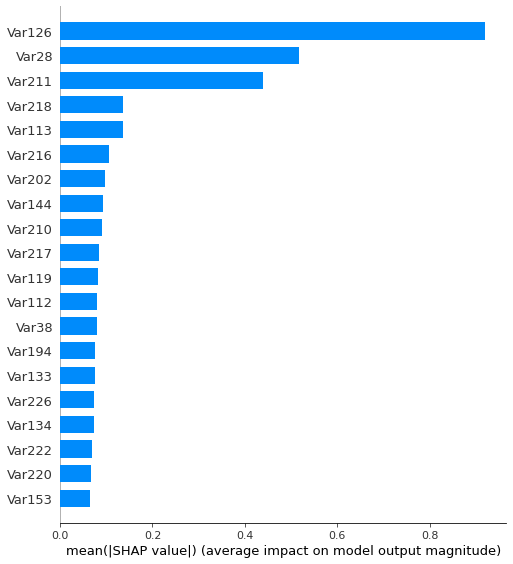

In [25]:
shap_values = shap.TreeExplainer(model_xgb).shap_values(train_X)
shap.summary_plot(shap_values, train_X, plot_type="bar")

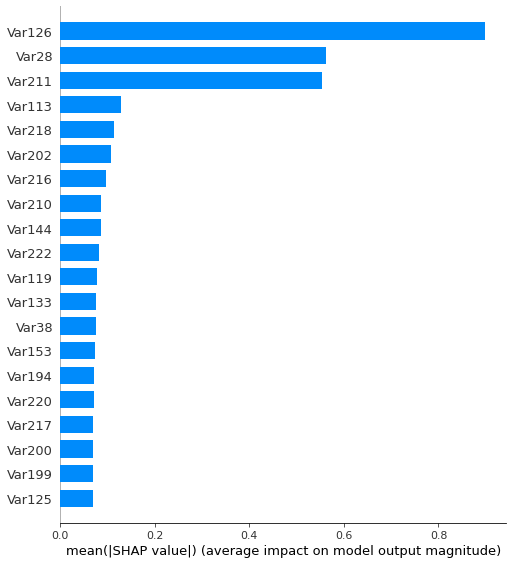

In [26]:
shap_values_paper = shap.TreeExplainer(model_xgb_paper).shap_values(train_X)
shap.summary_plot(shap_values_paper, train_X, plot_type="bar")

In [50]:
train_X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1]

Index(['age', 'martial_status', 'relationship', 'capital_gain',
       'education_num', 'hours_per_week', 'fnlwgt', 'occupation',
       'capital_loss', 'sex', 'workclass', 'education', 'race',
       'native_country'],
      dtype='object')

In [29]:
df_compare = pd.DataFrame([train_X.columns[x[0]] for x in importance_lgbm], columns=["LightGBM"])
df_compare["LightGBM_Paper"] = [train_X.columns[x[0]] for x in importance_lgbm]
df_compare["XGBoost"] = [x[0] for x in importance_xgb] + list(set(train_X.columns[:-1]) - set([x[0] for x in importance_xgb])) + [train_X.columns[-1]]
df_compare["XGBoost_Paper"] = [x[0] for x in importance_xgb_paper] + list(set(train_X.columns[:-1]) - set([x[0] for x in importance_xgb_paper])) + [train_X.columns[-1]]
df_compare["SHAP_XGBoost"] = train_X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1]
df_compare["SHAP_XGBoost_Paper"] = train_X.columns[np.argsort(np.abs(shap_values_paper).mean(0))][::-1]
df_compare["TabNet"] = [train_X.columns[x[0]] for x in importance_tabnet]
df_compare["TabNet_Paper"] = [train_X.columns[x[0]] for x in importance_tabnet_paper]

In [30]:
df_compare.head(10)

,LightGBM,LightGBM_Paper,XGBoost,XGBoost_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper
0,Var202,Var202,Var126,Var113,Var126,Var126,Var211,Var126
1,Var198,Var198,Var113,Var202,Var28,Var28,Var70_imputed,Var205
2,Var192,Var192,Var202,Var126,Var211,Var211,Var202,Var96
3,Var199,Var199,Var217,Var28,Var218,Var113,Var220,Var141_imputed
4,Var126,Var126,Var28,Var217,Var113,Var218,Var82_imputed,Var41
5,Var204,Var204,Var220,Var222,Var216,Var202,Var129,Var172
6,Var28,Var28,Var81,Var199,Var202,Var216,Var175,Var11_imputed
7,Var217,Var217,Var222,Var198,Var144,Var210,Var47_imputed,Var28
8,Var216,Var216,Var199,Var220,Var210,Var144,Var84_imputed,Var209_imputed
9,Var197,Var197,Var214,Var81,Var217,Var222,Var80,Var60_imputed


In [31]:
top_3 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:3, col1]) & set(df_compare.loc[:3, col2])))
        top_3.append(d)
top_3_data = pd.DataFrame(top_3, columns=["Model1", "Model2", "Sim"])
    

In [32]:
pd.pivot_table(top_3_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,LightGBM_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper,XGBoost,XGBoost_Paper
Model1,,,,,,,,
LightGBM,4,4,0,0,1,0,1,1
LightGBM_Paper,4,4,0,0,1,0,1,1
SHAP_XGBoost,0,0,4,3,1,1,1,2
SHAP_XGBoost_Paper,0,0,3,4,1,1,2,3
TabNet,1,1,1,1,4,0,1,1
TabNet_Paper,0,0,1,1,0,4,1,1
XGBoost,1,1,1,2,1,1,4,3
XGBoost_Paper,1,1,2,3,1,1,3,4


In [33]:
top_5 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:3, col1]) & set(df_compare.loc[:5, col2])))
        top_5.append(d)
top_5_data = pd.DataFrame(top_5, columns=["Model1", "Model2", "Sim"])
    

In [34]:
pd.pivot_table(top_5_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,LightGBM_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper,XGBoost,XGBoost_Paper
Model1,,,,,,,,
LightGBM,4,4,0,1,1,0,1,1
LightGBM_Paper,4,4,0,1,1,0,1,1
SHAP_XGBoost,1,1,4,4,1,1,2,2
SHAP_XGBoost_Paper,1,1,4,4,1,1,3,3
TabNet,1,1,1,2,4,0,2,1
TabNet_Paper,1,1,1,1,0,4,1,1
XGBoost,2,2,2,3,1,1,4,4
XGBoost_Paper,2,2,3,4,1,1,4,4


In [35]:
top_10 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:3, col1]) & set(df_compare.loc[:5, col2])))
        top_10.append(d)
top_10_data = pd.DataFrame(top_10, columns=["Model1", "Model2", "Sim"])
    

In [36]:
pd.pivot_table(top_10_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,LightGBM_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper,XGBoost,XGBoost_Paper
Model1,,,,,,,,
LightGBM,4,4,0,1,1,0,1,1
LightGBM_Paper,4,4,0,1,1,0,1,1
SHAP_XGBoost,1,1,4,4,1,1,2,2
SHAP_XGBoost_Paper,1,1,4,4,1,1,3,3
TabNet,1,1,1,2,4,0,2,1
TabNet_Paper,1,1,1,1,0,4,1,1
XGBoost,2,2,2,3,1,1,4,4
XGBoost_Paper,2,2,3,4,1,1,4,4
